# Analyze experiments
Run the post-processing needed to compare different runs.

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np

Configuration

In [30]:
run_dir = Path('prod-runs/8KNL-8V100-continuous-parsl-redis/')

## Load in the Results
We want the runtimes and system hostnames so we can measure how many tasks are running concurrently

In [31]:
def load_results(path: Path) -> pd.DataFrame:
    """Load the results for a certain run
    
    Args:
        path: Path to the run
    Returns:
        Dataframe of all results
    """
    
    # Loop over inference, training, and simulation
    output = []
    for task in ['inference', 'training', 'simulation']:
        # Get the results
        results = pd.read_json(path / f'{task}-results.json', lines=True)
        
        # Store make some metadata easier to get
        results['task'] = task
        results['hostname'] = results['worker_info'].apply(lambda x: x.get('hostname', 'nidXXXXX') if x is not None else 'nidXXXXX')
        
        # Mark the machine running
        def _get_machine(hostname):
            if hostname.startswith('lambda'):
                return 'lambda'
            elif hostname.startswith('nid'):
                return 'theta'
            elif hostname.startswith('thetagpu'):
                return 'thetagpu'
            else:
                raise ValueError(f'Unknown host: {hostname}')
        results['machine'] = results['hostname'].apply(_get_machine)
                
        # Make a shorter name for the task type
        def _get_task(method):
            if method.endswith('simulation'):
                return 'simulation'
            elif method.startswith('evaluate'):
                return 'inference'
            else:
                return 'training'
        
        results['task_type'] = results['method'].apply(_get_task)
        output.append(results)
        
    # Return sorted by 
    output = pd.concat(output)
    output.sort_values('time_compute_started', inplace=True, ignore_index=True)
    return output

In [32]:
results = load_results(run_dir)

## Plot the Utilization over Time
Without factoring out queue times.

First step is to mark when the utilization changes (at the beginning and end of jobs)

In [33]:
def get_utilization_over_time(results: pd.DataFrame) -> pd.DataFrame:
    """Get the utilization of all machines over time.
    
    Args:
        results: Result data for all tasks
    Returns:
        Utilization of each system over time
    """
    
    # Store the times at which tasks begin or end
    steps = []
    for rid, task in results.iterrows():
        for t, c in zip([task['time_compute_started'], 
                         task['time_compute_started'] + task['time_async_resolve_proxies'] + task['time_deserialize_inputs'] + task['time_running'] + task['time_serialize_results']],
                        [1, -1]):
            steps.append({
                'task_type': task['task_type'],
                'timestamp': t,
                'machine': task['machine'],
                'change': c
            })
    
    # Sort by timestamp
    steps = pd.DataFrame(steps)
    steps.sort_values('timestamp', inplace=True, ignore_index=True)
    
    # Normalize the walltimes for the results and the 
    steps['walltime'] = steps['timestamp'] - steps['timestamp'].min()
    results['walltime'] = results['time_result_received'] - steps['timestamp'].min()
    
    # Get the utilization for machine and by task
    machines = set(steps['machine'])
    task_types = set(steps['task_type'])
    total_used = dict((x, 0) for x in list(machines) + list(task_types))
    utilization = []
    for rid, row in steps.iterrows():
        total_used[row['machine']] += row['change']
        total_used[row['task_type']] += row['change']
        utilization.append(total_used.copy())
    utilization = pd.DataFrame(utilization)
    utilization['total'] = utilization[machines].sum(axis=1)
    
    # Append it to the tracking
    utilization = pd.concat((steps, utilization), axis=1)
    
    return utilization

In [34]:
utilization = get_utilization_over_time(results)

Factor out the idle times (due to jobs waiting in queue)

In [35]:
def remove_queue_times(utilization: pd.DataFrame, results: pd.DataFrame, minimum_span=30):
    """Remove the times the system was stuck waiting for nodes to be available
    
    Args:
        utilization: Dataframe containing the utilization over time
        results: Dataframe containing 
        minimum_span: Minimum time to declare a utilization absence due to queues
    """
    
    # Get the times where the system is completely idle
    stop_use = utilization.query('total==0').index[0:-1]  # Last one is shutdown
    
    # Find those where the downtime is honger than the minimum span
    is_longer = (utilization.loc[stop_use + 1, 'walltime'].values - utilization.loc[stop_use, 'walltime']) > minimum_span
    queue_stops = stop_use[is_longer]
    
    # Compute the time spent in queue for each pause
    queue_times = utilization.loc[queue_stops + 1, 'walltime'].values - utilization.loc[queue_stops, 'walltime']
    
    # Remove that time from jobs that occur after each time
    queue_starts = utilization.loc[queue_stops, 'walltime']
    for frame in (utilization, results):
        frame['time_queueing'] = 0
        for queue_start, queue_time in zip(queue_starts, queue_times):
            frame.loc[frame['walltime'] > queue_start, 'time_queueing'] += queue_time
        
        frame['walltime'] -= frame['time_queueing']
remove_queue_times(utilization, results)

Plot by the machine and task type

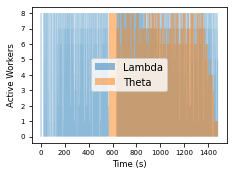

In [39]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

for machine in set(results['machine']):
#    if machine != "thetagpu": continue
    ax.fill_between(utilization['walltime'], utilization[machine], step='post', label=machine.capitalize(), alpha=0.5)

#ax.set_xlim(0, 100)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Active Workers')

ax.legend(loc='center')
fig.savefig('figures/theta-utilization.png', dpi=320)

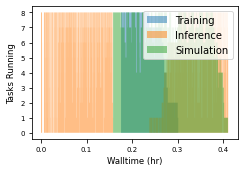

In [40]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

for task_type in set(results['task_type']):
    ax.fill_between(utilization['walltime'] / 3600, utilization[task_type], step='post', label=task_type.capitalize(), alpha=0.5)

#ax.set_xlim(0, 0.75)
#ax.set_ylim(0, 8)


ax.set_xlabel('Walltime (hr)')
ax.set_ylabel('Tasks Running')

ax.legend()
fig.tight_layout()

## Assess the Optimizer Performance
See the results of a simulation as a function of time

In [41]:
simulation_results = results.query('task_type == "simulation" and success').copy()

In [42]:
simulation_results['ip'] = simulation_results['task_info'].apply(lambda x: x['ip']['xtb-vacuum'])

(0.0, 0.4225213611655765)

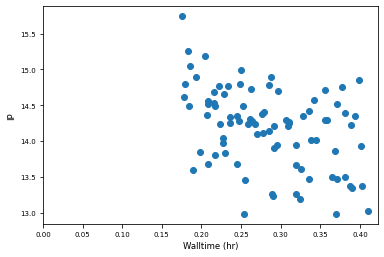

In [43]:
fig, ax = plt.subplots()

ax.scatter(simulation_results['walltime'] / 3600, simulation_results['ip'])

ax.set_xlabel('Walltime (hr)')
ax.set_ylabel('IP')

ax.set_xlim(0, max(ax.get_xlim()))

Plot IP over cumulative simulation time

In [44]:
simulation_results['cum_runtime'] = simulation_results['time_running'].cumsum()

(0.0, 1.8165892944164224)

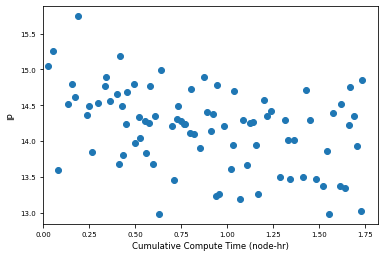

In [45]:
fig, ax = plt.subplots()

ax.scatter(simulation_results['cum_runtime'] / 3600, simulation_results['ip'])

ax.set_xlabel('Cumulative Compute Time (node-hr)')
ax.set_ylabel('IP')

ax.set_xlim(0, max(ax.get_xlim()))

## Run analysis all for experiments
Now that we have these functions, run them for all available experiments

In [46]:
experiment_dirs = [x for x in Path('prod-runs/').iterdir() if x.is_dir()]
print(f'Found {len(experiment_dirs)} experiments')

Found 2 experiments


In [47]:
for experiment in tqdm(experiment_dirs):
    results = load_results(experiment)
    utilization = get_utilization_over_time(results)
    remove_queue_times(utilization, results)
    
    simulation_results = results.query('task_type == "simulation" and success').copy()
    simulation_results.sort_values('walltime', inplace=True)
    simulation_results['ip'] = simulation_results['task_info'].apply(lambda x: x['ip']['xtb-vacuum'])
    
    # Save the experimental data
    results_dir = experiment / 'processed-results'
    results_dir.mkdir(exist_ok=True)
    
    results.to_csv(results_dir / 'all-tasks.csv', index=False)
    utilization.to_csv(results_dir / 'utilization.csv', index=False)
    simulation_results.to_csv(results_dir / 'simulation-tasks.csv', index=False)

100%|██████████| 2/2 [00:02<00:00,  1.25s/it]
